In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from sklearn.pipeline import Pipeline, make_pipeline

In [2]:
df = pd.read_csv('../../data/cars/cars.csv')

## Default cleaning

In [3]:
# I assume that the relationships between card brands and types are different and can't be captured by a single model
df = df.drop_duplicates()
df = df.query('Make == "Volkswagen"')
df = df[df['Model'].str.contains('Golf')]
df = df[df['Model'].isin(['Golf', 'Golf GTI', 'Golf Variant', 'Golf GTE', 'Golf Plus'])]

## Train test split

In [4]:
train, validation = train_test_split(df, test_size=0.25, random_state=42)  

## Cleaning

In [5]:
def clean_data(df):
    df = df.copy()

    # Feature names
    # Convert to dates
    date_features = ['Production_Date', 'Build_Year', 'Technical_Inspection', 'Last_Service']
    for feature in date_features:
        df[feature] = pd.to_datetime(df[feature], format='mixed')

    # Engine_Displacement
    def fix_engine_displacement(row):
        if row['Engine_Displacement'] > 10:
            return row['Engine_Displacement'] / 1000
        return row['Engine_Displacement']
    # Remove other energy
    df['Engine_Displacement'] = df.apply(fix_engine_displacement, axis=1)

    # Fuel Electric -> drop
    df = df[df['Fuel'] != 'Electric']

    # Category
    df['Category'] = df['Category'].replace(
        {'New Registered': "New", 
        'Classic': "Used", 
        'Demo': "Used", 
    })

    # Doors
    df['Doors'] = df['Doors'].replace(
        {2: 3, 
        4: 5, 
    })  

    # Rare Body types: Remove
    rare_body_types = ['SUV/Off-Road/Pick-Up', 'Overig', 'Cabrio', 'Sedan']
    df = df[~df['Body_Type'].isin(rare_body_types)]

    # Drive_Type: missing -> Front
    df['Drive_Type'] = df['Drive_Type'].replace(np.nan, 'Front')

    # Transmission: Semi-automatic -> Automatic
    df['Transmission'] = df['Transmission'].replace('Semi-automatic', 'Automatic')

    current_date = pd.to_datetime('2025-07-01')
    df['Age_Months'] = (current_date.year - df['Production_Date'].dt.year) * 12 + (current_date.month - df['Production_Date'].dt.month)

    del df['Make']
    del df['Seats']
    del df['Non_Smoker_Car']
    del df['Warranty']
    del df['Last_Service']
    del df['Electric_Range']
    del df['Other_Energy_Sources']
    del df['Production_Year']
    del df['Build_Year']
    del df['Technical_Inspection']
    del df['Production_Date']

    categorical_features = ['Model', 'Color', 'Body_Type', 'Drive_Type',
       'Transmission', 'Emission_Class', 'Fuel', 'Category',
       'Interior_Material', 'Interior_Color', 'Paint_Type', 'Doors']
    
    # Convert to categorical
    for feature in categorical_features:
        df[feature] = df[feature].astype('category')

    return df

In [6]:
train_clean = clean_data(train)
validation_clean = clean_data(validation)

In [7]:
categorical_features = train_clean.select_dtypes(include=['category']).columns.tolist()
numerical_features = [f for f in train_clean.columns if f not in categorical_features + ['Price']]

In [8]:
X_train, y_train = train_clean[numerical_features + categorical_features], train_clean['Price']
X_validation, y_validation = validation_clean[numerical_features + categorical_features], validation_clean['Price']

## Score to beat

In [9]:
from sklearn.ensemble import RandomForestRegressor

model = LinearRegression()

preprocessing = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[
            ('encoder', TargetEncoder(target_type='continuous', random_state=42)),
        ]), categorical_features),
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler()),
        ]), numerical_features),
    ])

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('imputing', IterativeImputer(estimator=RandomForestRegressor(max_depth=10), random_state=42)),
    ('model', model)
])

pipeline.fit(X_train, y_train)

print(pipeline.score(X_train, y_train),
    pipeline.score(X_validation, y_validation))

0.9208045943997951 0.8916550805161751


## Some visualisation

Text(0, 0.5, 'Feature')

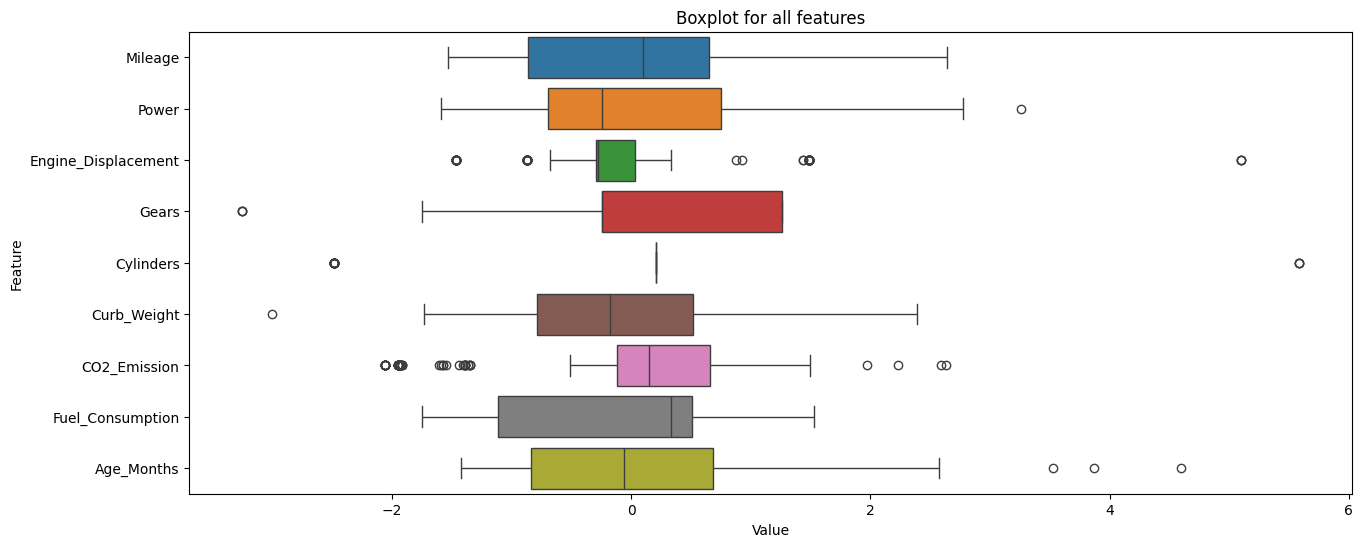

In [16]:
scaler = StandardScaler()
X_train_scaled_numerical = pd.DataFrame(scaler.fit_transform(X_train[numerical_features]),
                              columns=numerical_features,
                              index=X_train.index)

plt.figure(figsize=(15,6))
sns.boxplot(data=X_train_scaled_numerical, orient='h')
plt.title("Boxplot for all features")
plt.xlabel("Value")
plt.ylabel("Feature")

Text(0, 0.5, 'Feature')

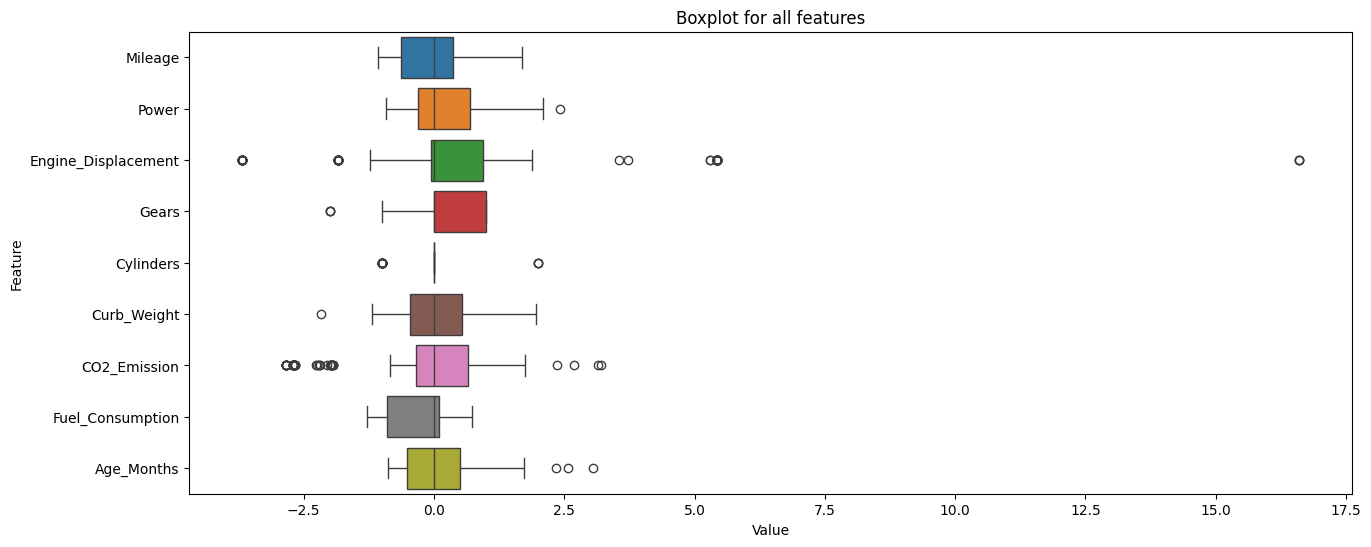

In [18]:
scaler = RobustScaler()
X_train_scaled_numerical = pd.DataFrame(scaler.fit_transform(X_train[numerical_features]),
                              columns=numerical_features,
                              index=X_train.index)

plt.figure(figsize=(15,6))
sns.boxplot(data=X_train_scaled_numerical, orient='h')
plt.title("Boxplot for all features")
plt.xlabel("Value")
plt.ylabel("Feature")

Text(0, 0.5, 'Residuals')

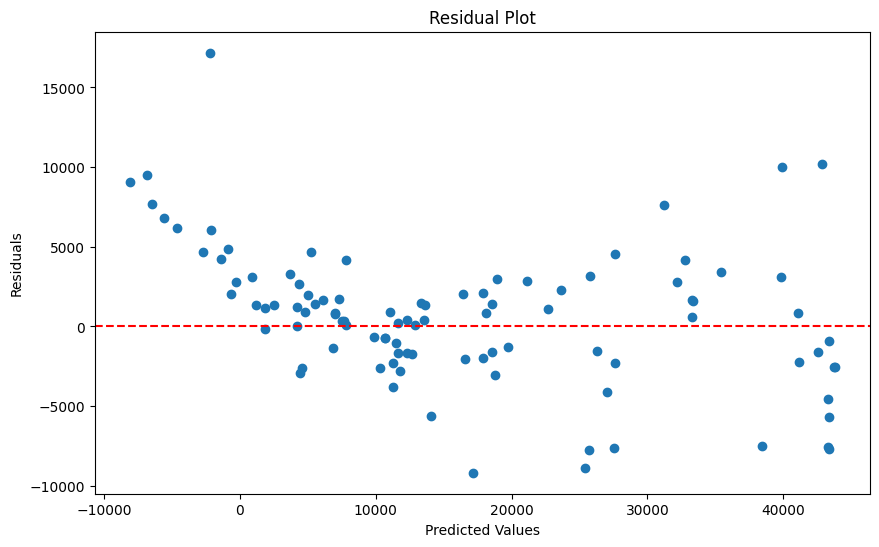

In [19]:
from sklearn.ensemble import RandomForestRegressor

model = LinearRegression()

preprocessing = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[
            ('encoder', TargetEncoder(target_type='continuous', random_state=42)),
        ]), categorical_features),
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler()),
        ]), numerical_features),
    ])

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('imputing', IterativeImputer(estimator=RandomForestRegressor(max_depth=10), random_state=42)),
    ('model', model)
])

pipeline.fit(X_train, y_train)

# Residual plot
y_pred = pipeline.predict(X_validation)
residuals = y_validation - y_pred
plt.figure(figsize=(10,6))
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")


## Outlier removal with z-scores

In [24]:
# Remove outliers with z-scores sigma > 3
z_scores = np.abs((X_train[numerical_features] - X_train[numerical_features].mean()) / X_train[numerical_features].std())
outliers = (z_scores > 3).any(axis=1)
X_train_no_outliers = X_train[~outliers]
y_train_no_outliers = y_train[~outliers]

model = LinearRegression()

preprocessing = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[
            ('encoder', TargetEncoder(target_type='continuous', random_state=42)),
        ]), categorical_features),
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler()),
        ]), numerical_features),
    ])

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('imputing', IterativeImputer(estimator=RandomForestRegressor(max_depth=10), random_state=42)),
    ('model', model)
])

pipeline.fit(X_train_no_outliers, y_train_no_outliers)

print(pipeline.score(X_train, y_train),
    pipeline.score(X_validation, y_validation))

0.9080641600722412 0.847389559629298


## Outlier removal with Mahalanobis

In [30]:
# Now the same but with mahalanobis from sklearn.covariance import EmpiricalCovariance
from sklearn.covariance import EmpiricalCovariance

X_train_simple_fill = X_train[numerical_features].fillna(X_train[numerical_features].mean())
mahal = EmpiricalCovariance()
mahal.fit(X_train_simple_fill)
mahal_dist = mahal.mahalanobis(X_train_simple_fill)
outliers = mahal_dist > np.percentile(mahal_dist, 99)
X_train_no_outliers = X_train[~outliers]
y_train_no_outliers = y_train[~outliers]

model = LinearRegression()

preprocessing = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[
            ('encoder', TargetEncoder(target_type='continuous', random_state=42)),
        ]), categorical_features),
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler()),
        ]), numerical_features),
    ])

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('imputing', IterativeImputer(estimator=RandomForestRegressor(max_depth=10), random_state=42)),
    ('model', model)
])

pipeline.fit(X_train_no_outliers, y_train_no_outliers)

print(pipeline.score(X_train, y_train),
    pipeline.score(X_validation, y_validation))


0.920086445981569 0.8940483032073159


## Outlier removal with Isolation forest

In [41]:
iso_forest = IsolationForest(contamination=0.01, random_state=42)

X_train_simple_fill = X_train[numerical_features].fillna(X_train[numerical_features].mean())
iso_forest.fit(X_train_simple_fill)
outliers = iso_forest.predict(X_train_simple_fill) == -1
X_train_no_outliers = X_train[~outliers]
y_train_no_outliers = y_train[~outliers]

model = LinearRegression()

preprocessing = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[
            ('encoder', TargetEncoder(target_type='continuous', random_state=42)),
        ]), categorical_features),
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler()),
        ]), numerical_features),
    ])

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('imputing', IterativeImputer(estimator=RandomForestRegressor(max_depth=10), random_state=42)),
    ('model', model)
])

pipeline.fit(X_train_no_outliers, y_train_no_outliers)

print(pipeline.score(X_train, y_train),
    pipeline.score(X_validation, y_validation))


0.9173594534113487 0.8953702442904456


In [ ]:
model = LinearRegression()

preprocessing = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[
            ('encoder', TargetEncoder(target_type='continuous', random_state=42)),
        ]), categorical_features),
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler()),
        ]), numerical_features),
    ])

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('imputing', IterativeImputer(estimator=RandomForestRegressor(max_depth=10), random_state=42))
])

pipeline.fit(X_train, y_train)

X_train_processed = pipeline.transform(X_train)


In [ ]:
# Now after the processing step
iso_forest = IsolationForest(contamination=0.01, random_state=42)

iso_forest.fit(X_train_processed)

outliers = iso_forest.predict(X_train_processed) == -1
X_train_processed_no_outliers = X_train_processed[~outliers]
y_train_no_outliers = y_train[~outliers]
X_validation_processed = pipeline.transform(X_validation)

model = LinearRegression()

model.fit(X_train_processed_no_outliers, y_train_no_outliers)
print(model.score(X_train_processed_no_outliers, y_train_no_outliers),
    model.score(X_validation_processed, y_validation))

0.9184881679370753 0.8811375206531535


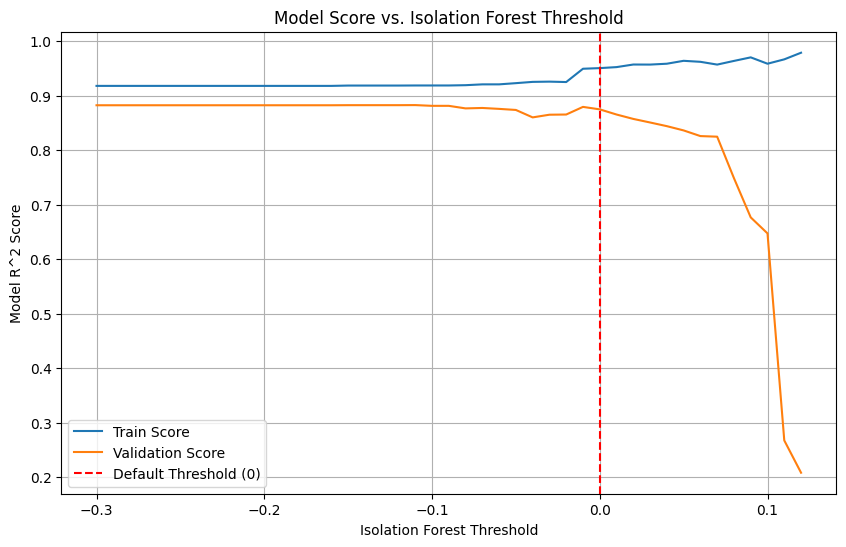

In [52]:
# Now after the processing step
iso_forest = IsolationForest(random_state=42)

iso_forest.fit(X_train_processed)

scores = iso_forest.decision_function(X_train_processed)

# Test different thresholds (from -2 to 2 in steps of 0.1)
thresholds = np.arange(-.3, .3, 0.01)
train_scores = []
validation_scores = []
for threshold in thresholds:
    outliers = scores < threshold
    X_train_processed_no_outliers = X_train_processed[~outliers]
    if X_train_processed_no_outliers.shape[0] < 10:
        train_scores.append(np.nan)
        validation_scores.append(np.nan)
        continue

    y_train_no_outliers = y_train[~outliers]
    X_validation_processed = pipeline.transform(X_validation)

    model = LinearRegression()
    model.fit(X_train_processed_no_outliers, y_train_no_outliers)
    train_scores.append(model.score(X_train_processed_no_outliers, y_train_no_outliers))
    validation_scores.append(model.score(X_validation_processed, y_validation))

plt.figure(figsize=(10,6))
plt.plot(thresholds, train_scores, label='Train Score')
plt.plot(thresholds, validation_scores, label='Validation Score')
plt.axvline(0, color='red', linestyle='--', label='Default Threshold (0)')
plt.title("Model Score vs. Isolation Forest Threshold")
plt.xlabel("Isolation Forest Threshold")
plt.ylabel("Model R^2 Score")
plt.legend()
plt.grid()